In [265]:
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from parse_dataset import parse_data

os.chdir("/Users/enrico.t/code/ml-reference-implementations")
df_train = parse_data('data/babI/tasks_1-20_v1-2/en/qa1_single-supporting-fact_train.txt')

In [266]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(stop_words=['is', 'the', 'to', 'where'])
corpus = df['fact1'].tolist() + df['fact2'].tolist() + df['question'].tolist() + df['answer'].tolist()
vectorizer.fit(corpus)

CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None,
        stop_words=['is', 'the', 'to', 'where'], strip_accents=None,
        token_pattern=u'(?u)\\b\\w\\w+\\b', tokenizer=None,
        vocabulary=None)

In [267]:
from sklearn import tree

y_train = df['answer']
X_train = pd.concat([
        pd.DataFrame(vectorizer.transform(df['fact1']).todense(), columns=vectorizer.get_feature_names()), 
        pd.DataFrame(vectorizer.transform(df['fact2']).todense(), columns=vectorizer.get_feature_names()), 
        pd.DataFrame(vectorizer.transform(df['question']).todense(), columns=vectorizer.get_feature_names())
    ], 
    axis=1)

df_test = parse_data('data/babI/tasks_1-20_v1-2/en/qa1_single-supporting-fact_test.txt')

y_test = df_test['answer']
X_test = pd.concat([
        pd.DataFrame(vectorizer.transform(df_test['fact1']).todense(), columns=vectorizer.get_feature_names()), 
        pd.DataFrame(vectorizer.transform(df_test['fact2']).todense(), columns=vectorizer.get_feature_names()), 
        pd.DataFrame(vectorizer.transform(df_test['question']).todense(), columns=vectorizer.get_feature_names())
    ], 
    axis=1)

In [318]:
from pandas_ml import ConfusionMatrix

clf = tree.DecisionTreeClassifier(
    max_features=20, 
    splitter='random', 
    criterion='entropy', 
    max_depth=6
)

clf.fit(X=X_train, y=y_train)

print clf.score(X=X_test, y=y_test)

y_predict = clf.predict(X_test)

0.508


In [312]:
from sklearn.model_selection import GridSearchCV
parameter_grid = { 
    'max_depth': range(1,10), 
    'max_features': range(1,45) + ['sqrt', 'log2', None],
    'criterion': ['entropy', 'gini'],
    'splitter': ['best', 'random'],
    # 'min_samples_split': range(2,10),
    # 'min_samples_leaf': range(1,10),
    # 'max_leaf_nodes': range(2,10) + [None],
}

grid_search = GridSearchCV(clf, param_grid = parameter_grid)
grid_search.fit(X_train, y_train)

print "Best Score: {}".format(grid_search.best_score_)
print "Best params: {}".format(grid_search.best_params_)

Best Score: 0.562
Best params: {'max_features': 35, 'splitter': 'best', 'criterion': 'entropy', 'max_depth': 5}


/Users/enrico.t/code/ml-reference-implementations/venv/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [298]:
cm = ConfusionMatrix(y_test, y_predict)
cm.print_stats()

Confusion Matrix:

Predicted  bathroom  bedroom  garden  hallway  kitchen  office  __all__
Actual                                                                 
bathroom         77       18      23       10        7      14      149
bedroom          23       88      22        9       12      17      171
garden           10       20     106        9       17      25      187
hallway          11       18      16       62       20      27      154
kitchen          17       24      18        6       78      14      157
office           28       17      24       11       10      92      182
__all__         166      185     209      107      144     189     1000


Overall Statistics:

Accuracy: 0.503
95% CI: (0.47154087501966263, 0.5344414162289287)
No Information Rate: ToDo
P-Value [Acc > NIR]: 9.598220701250601e-94
Kappa: 0.4019714486489609
Mcnemar's Test P-Value: ToDo


Class Statistics:

Classes                                 bathroom   bedroom    garden  \
Population                 

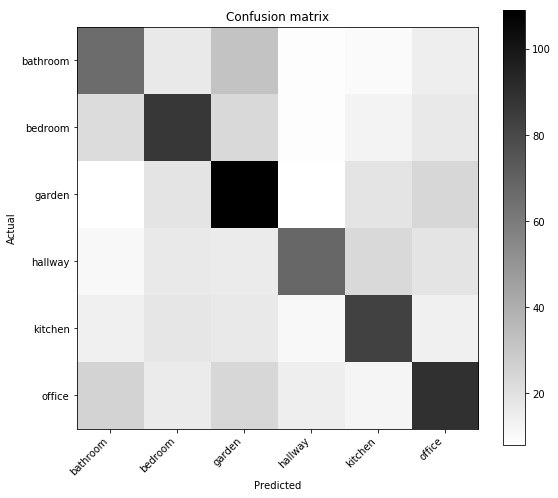

In [271]:
cm.plot()

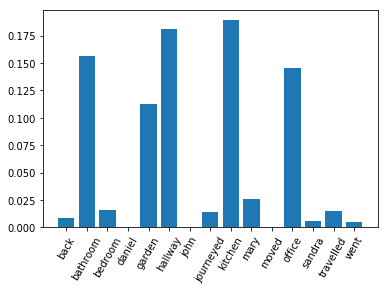

In [272]:
plt.bar(X_train.columns, clf.feature_importances_)
plt.xticks(rotation=60)
plt.show()

In [273]:
# observations:

# - 'is', 'the', 'where' and 'to' do not have any predictive power in this model
# - verbs seem to be less important predictors
# - occurance of nouns is a good predictor for answering a question, this makes sense
# - would have expected occurance of people's names to be important features, which is true

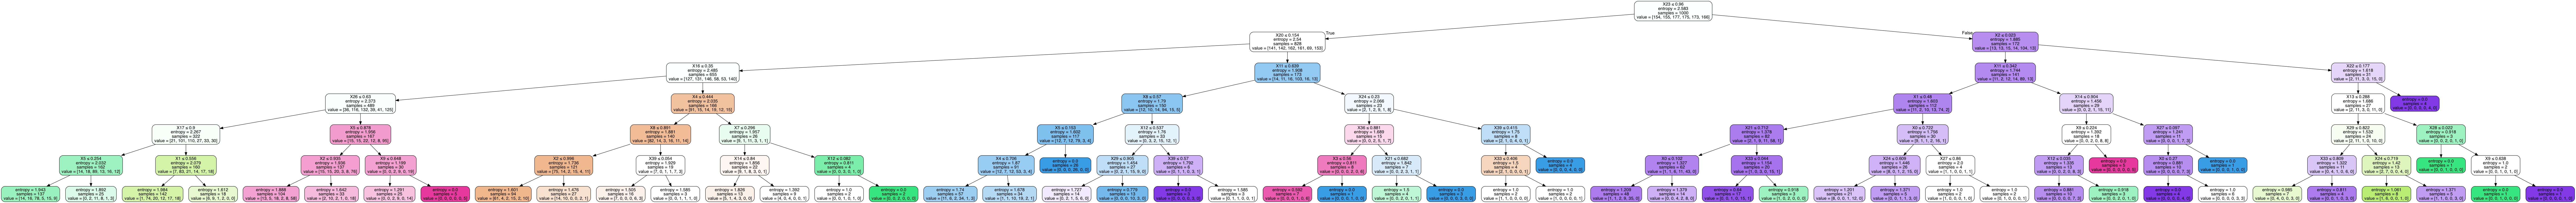

In [306]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True
)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [301]:
# observations:

# - this decision tree is way too big, it will probably be overfitting

# todo:
# - improve grid search
# - prune tree?
# - try ensemble methods
# - use folded cross validation?

In [276]:
# changelog:
# - gridsearch on parameters: accuracy from 0.475 to 0.512
# - removing commonly occuring stop words: accuracy from 0.456 to 0.475